# Градиентный спуск
## Задача поиска оптимальных коэффициентов полиномиальной модели

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from livelossplot import PlotLosses

Формируем синтетический датасет на основе полиномиальной функции с добавлением случайного шума:

${f(x) = \sum_{k=0}^{K-1}{w_k \cdot x^k} + \epsilon}$,

где ${w}$ - массив весов размера ${K}$

<function matplotlib.pyplot.show(close=None, block=None)>

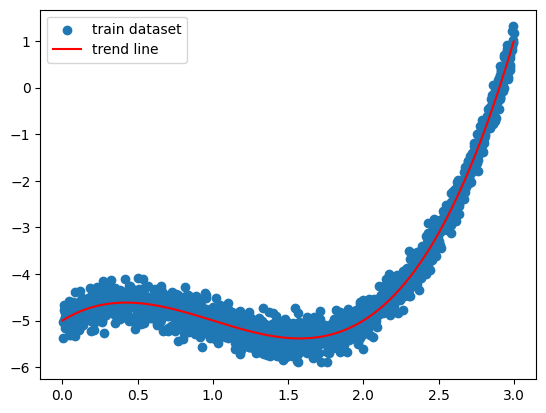

In [14]:
def f_trend(x):
    return x**3 - 3*x**2 + 2*x - 5

x_min = 0
x_max = 3
N_points = 2000
# Случайный набор x-ов.
X_train = np.random.uniform(low=x_min, high=x_max, size=(N_points,))
# Отклики с добавлением шума.
y_train = f_trend(X_train) + np.random.normal(0,0.2,N_points)

plt.scatter(X_train, y_train)
plt.plot(np.sort(X_train), f_trend(np.sort(X_train)), color='red')
plt.legend(['train dataset', 'trend line'])
plt.show

Определим полиномиальную функцию в общем виде:

In [15]:
def f_poly(X, w_coeff):
    Y = np.zeros_like(X)
    for n, x in enumerate(X):
        for idx, w in enumerate(w_coeff.tolist()[0]):
            Y[n] = Y[n] + w * x**idx
    return Y

Функция ошибки:

In [16]:
def loss_func(X, y, w_coeff):
    return np.sum((y - f_poly(X, w_coeff))**2)

In [17]:
def model_fit(X_train, y_train, learning_rate, tolerance, beta, batch_ratio, liveplot):
    if liveplot:
        liveloss = PlotLosses()
    batch_size = int(batch_ratio * len(X_train))
    
    # Коэффициенты (веса) инициилизируются нулями.
    w_coeff = np.zeros((1,len(learning_rate)))
    # Буфер коэффициентов.
    w_coeff_buff = w_coeff.copy()
    
    # Градиенты инициализируются ненулевыми значениями.
    w_grad = np.ones_like(w_coeff) * 1e-3
    
    # Аккумулятор для Momentum.
    G = np.zeros_like(w_coeff)

    losses = []
    # Инициализируем loss > tolerance.
    loss = 2 * tolerance
    i = 0
    while loss > tolerance:
        i += 1
        for k, w in enumerate(w_coeff.tolist()[0]):
            # Накопление "момента".
            G[0,k] = beta * G[0,k] + (1 - beta) * w_grad[0,k]
            # Шаг градиентного спуска.
            w_step = - learning_rate[k] * G[0,k]
            # Сбрасываем коэффициенты до ранее установленных.
            w_coeff_1 = w_coeff.copy()
            w_coeff_2 = w_coeff.copy()
            # Модификация только k-го коэффициента:
            w_coeff_1[0,k] = w + w_step
            w_coeff_2[0,k] = w + 2*w_step

            # Выборка случайных элементов (по индексам).
            batch_indices = np.random.choice(len(X_train), size=batch_size, replace=True)
            X_train_batch = [X_train[idx] for idx in batch_indices]
            y_train_batch = [y_train[idx] for idx in batch_indices]
            
            # Формируем массив значений функции потерь, для вычисления градиента. Массив состоит из 3х элементов.
            loss_func_grad = [loss_func(X_train_batch, y_train_batch, w_coeff  ),
                              loss_func(X_train_batch, y_train_batch, w_coeff_1),
                              loss_func(X_train_batch, y_train_batch, w_coeff_2)]
            # Массив градиента состоит из 3х точек с индексами [0, 1, 2]. Берем предпоследнюю.
            w_grad[0,k] = np.gradient(loss_func_grad, w_step)[1]
            
            # Обновление оного коэффициента в итоговом массиве.
            w_coeff_buff[0,k] = w_coeff_1[0,k]
        # Обновление всех коэффициентов.
        w_coeff = w_coeff_buff.copy()
        # Вычисление ошибки на полном датасете, при обновленных коэффициентах.
        loss = loss_func(X_train, y_train, w_coeff)
        # Накопление ошибки в отдельный массив для дальнейшей визуализации.
        losses.append(loss)
        
        if i % 100 == 0:
            print('Iteration:', i)
            print('Gradient:', np.round(w_grad,4))
            print('Weights:', np.round(w_coeff,4))
            print('MSE loss:', np.round(loss,4))
            if liveplot:
                if loss < 1000:
                    liveloss.update({'MSE loss': loss})
                    liveloss.draw()
    return w_coeff, losses

In [18]:
# Массив с коэффициентами при шагах обучения.
learning_rate = [1e-5, 1e-6, 1e-7, 1e-8, 1e-9]
#learning_rate = [1e-6, 1e-6, 1e-6, 1e-6, 1e-6]

# Включен Momentum.
# Обучение на батчах.
weights_1, losses_1 = model_fit(X_train, y_train, learning_rate, tolerance=1e-2, beta=0.9, batch_ratio=0.1, liveplot=False)

Iteration: 100
Gradient: [[1080.6926 1186.0099 1619.2532 1556.5892 3644.789 ]]
Weights: [[-1.2749e+00 -1.6200e-01 -2.6800e-02 -4.8000e-03 -9.0000e-04]]
MSE loss: 19483.4896
Iteration: 200
Gradient: [[  607.1605   451.006    197.2862 -1093.3716 -2748.1797]]
Weights: [[-2.1385e+00 -2.5120e-01 -3.7700e-02 -5.8000e-03 -9.0000e-04]]
MSE loss: 11322.2465
Iteration: 300
Gradient: [[  437.366    296.9573  -442.6372 -2916.8167 -8686.2125]]
Weights: [[-2.6759e+00 -2.8890e-01 -3.7400e-02 -4.5000e-03 -3.0000e-04]]
MSE loss: 8340.196
Iteration: 400
Gradient: [[ 3.0840130e+02 -5.8083000e+00 -7.7487580e+02 -1.6674791e+03
  -7.2143797e+03]]
Weights: [[-3.0318e+00 -2.9850e-01 -3.2200e-02 -1.9000e-03  6.0000e-04]]
MSE loss: 6940.7896
Iteration: 500
Gradient: [[   132.6268   -168.1429   -949.7415  -2963.4915 -12005.8911]]
Weights: [[-3.2762e+00 -2.9390e-01 -2.4300e-02  1.4000e-03  1.6000e-03]]
MSE loss: 6079.4881
Iteration: 600
Gradient: [[  178.7013   -11.6328  -566.5923 -3124.5613 -8653.3476]]
Weights:

KeyboardInterrupt: 

In [ ]:
# Отключен Momentum.
# Обучение на батчах.
weights_2, losses_2 = model_fit(X_train, y_train, learning_rate, tolerance=1e-2, beta=0, batch_ratio=0.1, liveplot=False)

In [ ]:
# Отключен Momentum.
# Обучение на полном датасете.
weights_3, losses_3 = model_fit(X_train, y_train, learning_rate, tolerance=1e-2, beta=0, batch_ratio=1.0, liveplot=False)